In [1]:
import requests
import csv
from datetime import datetime

API_KEY = 'c29a1583e9d54bf180f180516250106'
CITIES = ['Bangalore', 'Mysore']
URL_TEMPLATE = 'https://api.weatherapi.com/v1/current.json?key={}&q={}'

# Prepare list for weather data
weather_data = []

for city in CITIES:
    url = URL_TEMPLATE.format(API_KEY, city)
    response = requests.get(url)
    data = response.json()

    if response.status_code == 200:
        current = data['current']
        city_data = {
            'City': city,
            'Date': datetime.now().strftime('%Y-%m-%d'),
            'Time': datetime.now().strftime('%H:%M:%S'),
            'Temperature (°C)': current['temp_c'],
            'Humidity (%)': current['humidity'],
            'Condition': current['condition']['text'],
            'Wind Speed (kph)': current['wind_kph']
        }
        weather_data.append(city_data)

        # ✅ Print weather data
        print(f"\n📍 Weather in {city}")
        for key, value in city_data.items():
            print(f"{key}: {value}")
    else:
        print(f"❌ Error fetching data for {city}: {data.get('error', {}).get('message')}")

# Save the data to CSV and print size (rows x cols)
if weather_data:
    filename = 'live_weather_data.csv'
    fieldnames = weather_data[0].keys()
    with open(filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(weather_data)

    num_rows = len(weather_data)
    num_cols = len(fieldnames)

    print(f"\n✅ Weather data saved to {filename}")
    print(f"📊 Data Shape: {num_rows} rows × {num_cols} columns")



📍 Weather in Bangalore
City: Bangalore
Date: 2025-07-23
Time: 18:52:05
Temperature (°C): 21.4
Humidity (%): 88
Condition: Partly cloudy
Wind Speed (kph): 27.7

📍 Weather in Mysore
City: Mysore
Date: 2025-07-23
Time: 18:52:06
Temperature (°C): 19.8
Humidity (%): 91
Condition: Patchy rain nearby
Wind Speed (kph): 22.0

✅ Weather data saved to live_weather_data.csv
📊 Data Shape: 2 rows × 7 columns


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

import pandas as pd
import zipfile

# Define base path
base_path = "/content/drive/My Drive"  # or add "/your_folder" if files are inside a folder

# Load CSVs
bengaluru_aqi = pd.read_csv(f"{base_path}/Bengaluru_AQIBulletins.csv")
mysuru_aqi = pd.read_csv(f"{base_path}/Mysuru_AQIBulletins.csv")

df = pd.read_csv("/content/drive/My Drive/AQI_Weather_Analyser_Project/DATA/final_AQI.zip")

# Step 5: Print shape and preview
print("✅ final_AQI shape:", df.shape)
print(df.head())

print("\n✅ bengaluru_aqi shape:", bengaluru_aqi.shape)
print(bengaluru_aqi.head())

print("\n✅ mysuru_aqi shape:", mysuru_aqi.shape)
print(mysuru_aqi.head())


✅ final_AQI shape: (1332059, 52)
                   Start_TS                  End_Date  PM25  PM10    NO  \
0  2010-01-01T00:00:00.000Z  2010-01-01T01:00:00.000Z   0.0   0.0  3.51   
1  2010-01-01T00:00:00.000Z  2010-01-01T01:00:00.000Z   0.0   0.0  0.85   
2  2010-01-01T01:00:00.000Z  2010-01-01T02:00:00.000Z   0.0   0.0  5.57   
3  2010-01-01T01:00:00.000Z  2010-01-01T02:00:00.000Z   0.0   0.0  1.19   
4  2010-01-01T02:00:00.000Z  2010-01-01T03:00:00.000Z   0.0   0.0  5.69   

     NO2    NOX    NH3   SO2    CO  ...  Rolling_PM10_max_7d  \
0  17.84  21.26   0.00  1.36  0.48  ...                  0.0   
1  21.07  21.91  32.51  4.30  0.45  ...                  0.0   
2  14.71  20.28   0.00  1.23  0.49  ...                  0.0   
3  20.41  21.60  31.99  1.22  0.35  ...                  0.0   
4  14.18  19.87   0.00  1.09  0.38  ...                  0.0   

   Rolling_NO2_mean  Lag_NO2_1h  Rolling_NO2_max_7d  Rolling_CO_mean  \
0         17.840000         NaN               21.07        

In [4]:
# Rename weather_data list to DataFrame
live_weather_df = pd.DataFrame(weather_data)

# Convert date columns to datetime
live_weather_df['Date'] = pd.to_datetime(live_weather_df['Date'])
bengaluru_aqi['date'] = pd.to_datetime(bengaluru_aqi['date'])
mysuru_aqi['date'] = pd.to_datetime(mysuru_aqi['date'])

# Standardize City names
bengaluru_aqi['City'] = 'Bangalore'
mysuru_aqi['City'] = 'Mysore'

# Combine AQI dataframes
aqi_df = pd.concat([bengaluru_aqi, mysuru_aqi], ignore_index=True)

# Merge live weather data with AQI data on City and Date
merged_df = pd.merge(live_weather_df, aqi_df, left_on=['City', 'Date'], right_on=['City', 'date'], how='left')


In [5]:
def get_weather_emoji(condition):
    condition = condition.lower()
    if 'clear' in condition:
        return '☀️'
    elif 'cloud' in condition:
        return '☁️'
    elif 'rain' in condition:
        return '🌧️'
    elif 'storm' in condition:
        return '⛈️'
    elif 'snow' in condition:
        return '❄️'
    else:
        return '🌈'

# Example usage
merged_df['Weather_Emoji'] = merged_df['Condition'].apply(get_weather_emoji)


In [6]:
'''import plotly.express as px

# Your DataFrame: bengaluru_aqi
fig = px.line(
    bengaluru_aqi,
    x='date',
    y='Index Value',
    title='Bangalore AQI Over Time (Historical)',
    markers=True
)

# Show interactive plot
fig.show()

# Save static PNG
fig.write_image("bangalore_aqi_plot.png", width=1000, height=600)'''


'import plotly.express as px\n\n# Your DataFrame: bengaluru_aqi\nfig = px.line(\n    bengaluru_aqi,\n    x=\'date\',\n    y=\'Index Value\',\n    title=\'Bangalore AQI Over Time (Historical)\',\n    markers=True\n)\n\n# Show interactive plot\nfig.show()\n\n# Save static PNG\nfig.write_image("bangalore_aqi_plot.png", width=1000, height=600)'

In [7]:
'''from google.colab import files
files.download('/content/bangalore_aqi_plot.png')'''


"from google.colab import files\nfiles.download('/content/bangalore_aqi_plot.png')"

In [8]:
import pandas as pd

# Assuming df is your loaded DataFrame from final_AQI.zip
df['Start_TS'] = pd.to_datetime(df['Start_TS'])
df['End_Date'] = pd.to_datetime(df['End_Date'])

# Check conversion
print(df[['Start_TS', 'End_Date']].head())


                   Start_TS                  End_Date
0 2010-01-01 00:00:00+00:00 2010-01-01 01:00:00+00:00
1 2010-01-01 00:00:00+00:00 2010-01-01 01:00:00+00:00
2 2010-01-01 01:00:00+00:00 2010-01-01 02:00:00+00:00
3 2010-01-01 01:00:00+00:00 2010-01-01 02:00:00+00:00
4 2010-01-01 02:00:00+00:00 2010-01-01 03:00:00+00:00


In [9]:
derived_cols = [col for col in df.columns if col.startswith(('Rolling_', 'Lag_'))] + ['AQI_CPCB', 'AQI_Category']

missing_counts = df[derived_cols].isnull().sum()
print(missing_counts)


Rolling_PM25_mean          0
Lag_PM25_1h                1
Rolling_Temperature_max    0
Rolling_PM10_mean          0
Lag_PM10_1h                1
Rolling_PM10_max_7d        0
Rolling_NO2_mean           0
Lag_NO2_1h                 1
Rolling_NO2_max_7d         0
Rolling_CO_mean            0
Lag_CO_1h                  1
Rolling_CO_max_7d          0
Rolling_SO2_mean           0
Lag_SO2_1h                 1
Rolling_SO2_max_7d         0
AQI_CPCB                   0
AQI_Category               0
dtype: int64


In [10]:
df[derived_cols] = df[derived_cols].ffill().fillna(0)



In [11]:
lag_cols = ['Lag_PM25_1h', 'Lag_PM10_1h', 'Lag_NO2_1h', 'Lag_CO_1h', 'Lag_SO2_1h']

# Drop rows with NaN in any lag column
df_clean = df.dropna(subset=lag_cols)

print(f"Shape before dropping: {df.shape}")
print(f"Shape after dropping: {df_clean.shape}")


Shape before dropping: (1332059, 52)
Shape after dropping: (1332059, 52)


In [12]:
df.nunique().sort_values()  # to check unique values per column


,0
AQI_Category,6
AQI_CPCB,501
Rolling_PM10_max_7d,936
Rolling_Temperature_max,1051
Rolling_CO_max_7d,1918
Rolling_SO2_max_7d,1970
Rolling_NO2_max_7d,1997
AQI_CO,4461
ETH_BENZENE,5142
Lag_CO_1h,9272


In [13]:
print(df.columns.tolist())


['Start_TS', 'End_Date', 'PM25', 'PM10', 'NO', 'NO2', 'NOX', 'NH3', 'SO2', 'CO', 'OZONE', 'BENZENE', 'TOLUENE', 'ETH_BENZENE', 'MP_XYLENE', 'O_XYLENE', 'TEMP_C', 'RH', 'WS', 'WD', 'SR', 'BP', 'VWS', 'PM_RATIO', 'NOX_TO_NO2', 'PM25_WIND_SCALED', 'HUMIDITY_TEMP_INDEX', 'AQI_PM25', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_OZONE', 'AQI_NH3', 'AQI_CPCB', 'AQI_Category', 'Start_TS_unix', 'Rolling_PM25_mean', 'Lag_PM25_1h', 'Rolling_Temperature_max', 'Rolling_PM10_mean', 'Lag_PM10_1h', 'Rolling_PM10_max_7d', 'Rolling_NO2_mean', 'Lag_NO2_1h', 'Rolling_NO2_max_7d', 'Rolling_CO_mean', 'Lag_CO_1h', 'Rolling_CO_max_7d', 'Rolling_SO2_mean', 'Lag_SO2_1h', 'Rolling_SO2_max_7d']


In [14]:
!pip install optuna
!pip install mlflow

In [15]:

import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



features = ['PM25', 'PM10', 'NO2', 'CO', 'SO2', 'OZONE', 'TEMP_C', 'RH', 'WS', 'WD']
target = 'AQI_CPCB'  # or 'PM25' if you're directly predicting PM2.5

# Drop rows with NA in selected columns
df_model = df[features + [target]].dropna()

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [18:53:37] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


✅ RMSE: 13.99
🚀 MLflow logging complete!


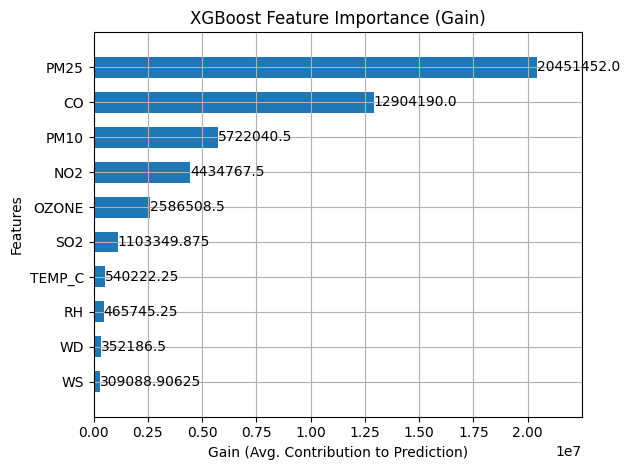

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.xgboost
from mlflow.models.signature import infer_signature
import os

# === 2. Feature selection (modify only if needed)
features = ['PM25', 'PM10', 'NO2', 'CO', 'SO2', 'OZONE', 'TEMP_C', 'RH', 'WS', 'WD']
target = 'AQI_CPCB'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# === 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 4. Start MLflow logging
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("AQI_Prediction")

with mlflow.start_run():
    # === 5. Train XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    # === 6. Predict & evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # === 7. Log parameters, metrics
    mlflow.log_params(model.get_params())
    mlflow.log_metric("rmse", rmse)

    # === 8. Save feature importance plot
    fig_path = "feature_importance.png"
    xgb.plot_importance(model, importance_type='gain',
                        xlabel='Gain (Avg. Contribution to Prediction)', height=0.6)
    plt.title("XGBoost Feature Importance (Gain)")
    plt.tight_layout()
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)

    # === 9. Log model with signature
    input_example = X_test.iloc[:5]
    signature = infer_signature(X_test, model.predict(X_test))
    mlflow.xgboost.log_model(
        model,
        name="xgb_model",
        input_example=input_example,
        signature=signature
    )

    print(f"✅ RMSE: {rmse:.2f}")
    print("🚀 MLflow logging complete!")


In [17]:
# Get feature importance as raw gain
importance_dict = model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
importances_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['Gain'])

# Normalize to percentages
importances_df['Gain %'] = 100 * importances_df['Gain'] / importances_df['Gain'].sum()

# Sort by importance descending
importances_df = importances_df.sort_values('Gain %', ascending=False)

# Rename feature column for clarity
importances_df.index.name = 'Feature'
importances_df.reset_index(inplace=True)

print(importances_df.round(2))


  Feature         Gain  Gain %
0    PM25  20451452.00   41.85
1      CO  12904190.00   26.41
2    PM10   5722040.50   11.71
3     NO2   4434767.50    9.07
4   OZONE   2586508.50    5.29
5     SO2   1103349.88    2.26
6  TEMP_C    540222.25    1.11
7      RH    465745.25    0.95
8      WD    352186.50    0.72
9      WS    309088.91    0.63


/tmp/ipython-input-18-3743835153.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


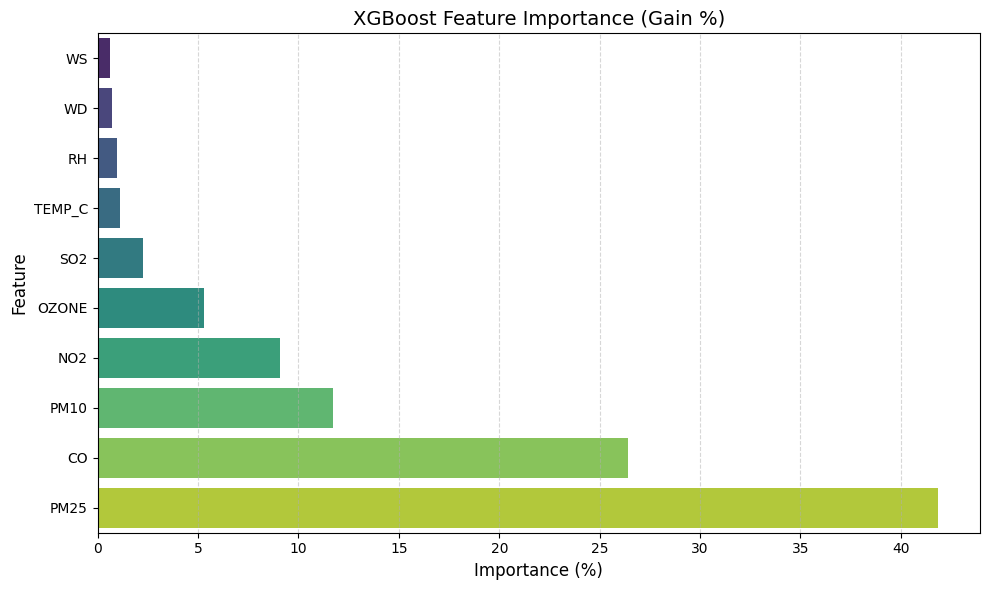

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort features for better display
importances_df = importances_df.sort_values("Gain %", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Gain %",
    y="Feature",
    data=importances_df,
    palette="viridis"
)

plt.title("XGBoost Feature Importance (Gain %)", fontsize=14)
plt.xlabel("Importance (%)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# === Save the plot ===
plt.savefig("xgboost_feature_importance.png", dpi=300, bbox_inches='tight')  # High-res
plt.show()


In [19]:
from google.colab import files
files.download("xgboost_feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8326/8326 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step
✅ MSE: 0.0120
📉 RMSE: 0.1096


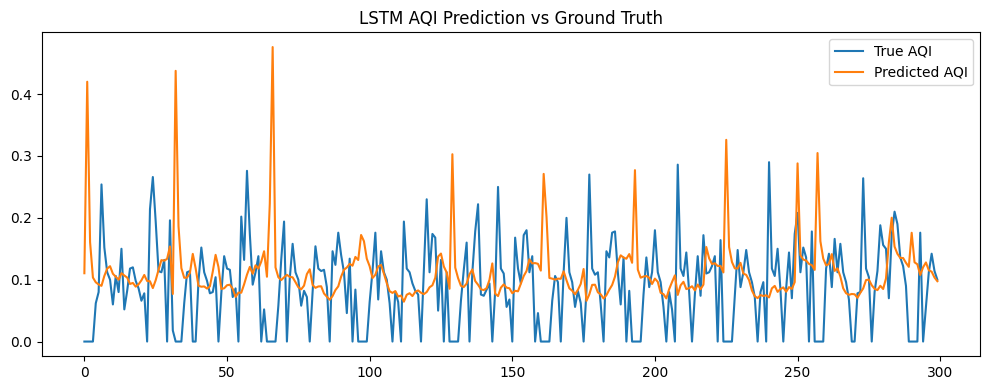

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# === 1. Load and prepare data ===

df = df.sort_values("Start_TS")

top_features = ['PM25', 'CO', 'PM10', 'NO2', 'OZONE', 'SO2']
target_col = 'AQI_CPCB'

data = df[top_features + [target_col]].dropna().copy()

# === 2. Normalize ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# === 3. Create sequences ===
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, :-1])  # features
        y.append(data[i, -1])             # target
    return np.array(X), np.array(y)

SEQ_LEN = 24
X, y = create_sequences(scaled_data, SEQ_LEN)

# === 4. Recreate Train/Test Split ===
split = int(0.8 * len(X))
X_test, y_test = X[split:], y[split:]

# === 5. Load Model and Predict ===
model = load_model("lstm_aqi_model.keras")
y_pred = model.predict(X_test)

# === 6. Evaluate ===
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"✅ MSE: {mse:.4f}")
print(f"📉 RMSE: {rmse:.4f}")


# === 7. Optional: Plot Predictions ===
plt.figure(figsize=(10, 4))
plt.plot(y_test[:300], label="True AQI")
plt.plot(y_pred[:300], label="Predicted AQI")
plt.title("LSTM AQI Prediction vs Ground Truth")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
import mlflow
print("MLflow version:", mlflow.__version__)


MLflow version: 3.1.4


In [28]:
# Create a proper input example with shape (1, 24, 6)
example_input = X_test[:1].tolist()


In [31]:
import mlflow.models
from mlflow.models.signature import infer_signature

# Pick one test example
input_example = X_test[:1]
prediction_example = model.predict(input_example)

signature = infer_signature(input_example, prediction_example)

mlflow.tensorflow.log_model(
    model,
    name="lstm_model_logged",
    input_example=input_example,
    signature=signature
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


In [33]:
info = mlflow.tensorflow.log_model(  # or mlflow.keras.log_model if you used that
    model,
    name="lstm_model_logged",
    input_example=input_example,
    signature=signature
)

# Print full details
print(f"Model URI: {info.model_uri}")
print(f"Run ID: {info.run_id}")
print(f"Artifact Path: {info.artifact_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Model URI: models:/m-3ea79f480b6a47e1800cb1866b3e7f4f
Run ID: None
Artifact Path: file:///content/mlruns/603149180463396499/models/m-3ea79f480b6a47e1800cb1866b3e7f4f/artifacts


Missing values before imputation:
 AQI_CO                49942
AQI_PM25              19202
AQI_NO2                6729
AQI_PM10              11131
NO2                       0
PM25                      0
NOX_TO_NO2           314220
AQI_OZONE              5219
PM10                      0
CO                        0
Rolling_NO2_mean          0
Rolling_CO_mean           0
Rolling_PM10_mean         0
dtype: int64
Missing values after imputation:
 AQI_CO               0
AQI_PM25             0
AQI_NO2              0
AQI_PM10             0
NO2                  0
PM25                 0
NOX_TO_NO2           0
AQI_OZONE            0
PM10                 0
CO                   0
Rolling_NO2_mean     0
Rolling_CO_mean      0
Rolling_PM10_mean    0
dtype: int64
✅ Data shape after cleanup: (1332059, 13)
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 7.12837
[100]	valid_0's rmse: 6.67109
[150]	valid_0's rmse: 6.45978
[200]	valid_0's rmse: 6.33901
[250]	valid_0's rmse

/tmp/ipython-input-35-285313453.py:108: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-285313453.py:110: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(fig_path)



✅ Evaluation Metrics:
RMSE : 5.8978
MAE  : 1.7099
R²   : 0.9932
MAPE : 5.99%
🚀 Model, plots, and metrics logged to MLflow successfully.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


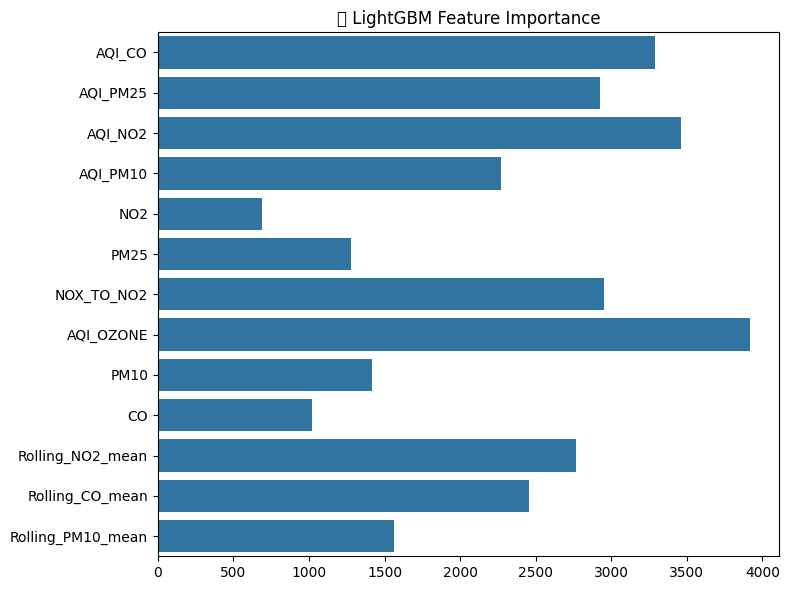

In [35]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import mlflow
import mlflow.lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# === 1. Define Features and Target ===
feature_cols = [
    'AQI_CO', 'AQI_PM25', 'AQI_NO2', 'AQI_PM10',
    'NO2', 'PM25', 'NOX_TO_NO2', 'AQI_OZONE',
    'PM10', 'CO', 'Rolling_NO2_mean', 'Rolling_CO_mean', 'Rolling_PM10_mean'
]
target_col = 'AQI_CPCB'

# === 2. Prepare Data ===
X = df[feature_cols]
y = df[target_col]

# Impute missing values in X
print("Missing values before imputation:\n", X.isnull().sum())
X = X.fillna(X.median())
print("Missing values after imputation:\n", X.isnull().sum())

# Drop rows with missing target
data = pd.concat([X, y], axis=1).dropna()
X = data[feature_cols]
y = data[target_col]

print(f"✅ Data shape after cleanup: {X.shape}")

# === 3. Train-Test Split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 4. LightGBM Dataset ===
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# === 5. Training Parameters ===
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

# === 6. Input Example ===
input_example = X_val.iloc[:1]

# === 7. Start MLflow Logging ===
mlflow.set_tracking_uri("file:///content/mlruns")  # Or change to your local path
mlflow.set_experiment("AQI_LightGBM_Model")

with mlflow.start_run(run_name="LightGBM Baseline with Median Impute"):
    mlflow.log_params(params)
    mlflow.log_param("n_train", len(X_train))
    mlflow.log_param("n_val", len(X_val))

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )

    mlflow.log_param("best_iteration", model.best_iteration)

    # === 8. Evaluate ===
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = (abs((y_val - y_pred) / y_val.replace(0, 1))).mean() * 100

    mlflow.log_metrics({
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "MAPE": mape
    })

    # === 9. Save Model ===
    mlflow.lightgbm.log_model(
        lgb_model=model,
        name="model",
        input_example=input_example
    )

    # === 10. Save Feature Importance Plot ===
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(
        x=model.feature_importance(),
        y=model.feature_name(),
        ax=ax
    )
    ax.set_title("📊 LightGBM Feature Importance")
    plt.tight_layout()
    fig_path = "feature_importance.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)

    # === 11. Save Predictions CSV ===
    pred_df = pd.DataFrame({
        "actual": y_val.values,
        "predicted": y_pred
    })
    pred_path = "val_predictions.csv"
    pred_df.to_csv(pred_path, index=False)
    mlflow.log_artifact(pred_path)

    print("\n✅ Evaluation Metrics:")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print("🚀 Model, plots, and metrics logged to MLflow successfully.")


In [36]:
from google.colab import files
files.download("feature_importance.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
'''import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import mlflow
import mlflow.lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlflow.models.signature import infer_signature

# === 1. Feature definitions ===
feature_cols = [
    'AQI_CO', 'AQI_PM25', 'AQI_NO2', 'AQI_PM10',
    'NO2', 'PM25', 'NOX_TO_NO2', 'AQI_OZONE', 'PM10', 'CO',
    'Rolling_NO2_mean', 'Rolling_CO_mean', 'Rolling_PM10_mean'
]
target_col = 'AQI_CPCB'

# === 2. Prepare data ===
X = df[feature_cols].fillna(df[feature_cols].median())
y = df[target_col]
data = pd.concat([X, y], axis=1).dropna()
X = data[feature_cols]
y = data[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 3. Define Optuna objective ===
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 2047),
        'max_depth': trial.suggest_int('max_depth', 4, 32),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'seed': 42
    }

    with mlflow.start_run(nested=True):
        mlflow.log_params(params)

        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dvalid],
            num_boost_round=1000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=50)
            ]
        )

        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        y_val_safe = y_val.replace(0, 1)
        mape = np.mean(np.abs((y_val - y_pred) / y_val_safe)) * 100

        mlflow.log_metrics({
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "mape": mape
        })

        return rmse

# === 4. Run Optuna Study ===
study = optuna.create_study(direction="minimize")
with mlflow.start_run(run_name="Optuna_LightGBM_Tuning"):
    study.optimize(objective, n_trials=10)

    # === 5. Train final model ===
    best_params = study.best_params
    best_params.update({
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'seed': 42
    })

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_val, label=y_val)

    best_model = lgb.train(
        best_params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )

    y_pred = best_model.predict(X_val, num_iteration=best_model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    y_val_safe = y_val.replace(0, 1)
    mape = np.mean(np.abs((y_val - y_pred) / y_val_safe)) * 100

    # === 6. Log final results ===
    mlflow.log_metrics({
        "final_rmse": rmse,
        "final_mae": mae,
        "final_r2": r2,
        "final_mape": mape
    })

    signature = infer_signature(X_val, y_pred)
    mlflow.lightgbm.log_model(
        best_model,
        name="model",  # ✅ new param replaces deprecated artifact_path
        signature=signature,
        input_example=X_val.head(2)
    )

# === 7. Output ===
print("\n🎯 Best trial results:")
print(f"Best RMSE: {study.best_value:.4f}")
print("Best Parameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")
'''

'import pandas as pd\nimport numpy as np\nimport lightgbm as lgb\nimport optuna\nimport mlflow\nimport mlflow.lightgbm\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nfrom mlflow.models.signature import infer_signature\n\n# === 1. Feature definitions ===\nfeature_cols = [\n    \'AQI_CO\', \'AQI_PM25\', \'AQI_NO2\', \'AQI_PM10\',\n    \'NO2\', \'PM25\', \'NOX_TO_NO2\', \'AQI_OZONE\', \'PM10\', \'CO\',\n    \'Rolling_NO2_mean\', \'Rolling_CO_mean\', \'Rolling_PM10_mean\'\n]\ntarget_col = \'AQI_CPCB\'\n\n# === 2. Prepare data ===\nX = df[feature_cols].fillna(df[feature_cols].median())\ny = df[target_col]\ndata = pd.concat([X, y], axis=1).dropna()\nX = data[feature_cols]\ny = data[target_col]\n\nX_train, X_val, y_train, y_val = train_test_split(\n    X, y, test_size=0.2, random_state=42\n)\n\n# === 3. Define Optuna objective ===\ndef objective(trial):\n    params = {\n        \'objective\': \'regression\'

In [40]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import mlflow
import mlflow.lightgbm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlflow.models.signature import infer_signature
import joblib

# === 1. Load the trained model ===
model = joblib.load("lgb_regressor.pkl")  # Make sure this path is correct

# === 2. Reuse data and best params ===
best_params = {
    'learning_rate': 0.019441889009495675,
    'num_leaves': 843,
    'max_depth': 23,
    'min_data_in_leaf': 57,
    'lambda_l1': 0.34764957462656026,
    'lambda_l2': 0.025683287618678004,
    'feature_fraction': 0.82725183139095,
    'bagging_fraction': 0.5656402337445862,
    'bagging_freq': 9,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42
}

# === 3. Ensure X_val and y_val are prepared ===
# If not already done:
# X_val = df[feature_cols].fillna(...); y_val = df[target_col]

# === 4. Predict and evaluate ===
y_pred = model.predict(X_val)
y_val_safe = y_val.replace(0, 1)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mape = np.mean(np.abs((y_val - y_pred) / y_val_safe)) * 100

# === 5. Log everything to MLflow ===
with mlflow.start_run(run_name="Log_Pretrained_LGBM_Joblib"):
    mlflow.log_params(best_params)
    mlflow.log_metrics({
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "MAPE": mape
    })

    signature = infer_signature(X_val, y_pred)

    mlflow.lightgbm.log_model(
        lgb_model=model,
        name="model",
        input_example=X_val.head(2),
        signature=signature,
        registered_model_name="LGBM_Regressor_Optuna"
    )

print("✅ Model and metrics logged to MLflow successfully.")


✅ Model and metrics logged to MLflow successfully.


Successfully registered model 'LGBM_Regressor_Optuna'.
Created version '1' of model 'LGBM_Regressor_Optuna'.


In [41]:
# Check unique categories and their counts
print("Unique AQI categories and counts:")
print(df['AQI_Category'].value_counts(dropna=False))

# Check for null values
null_count = df['AQI_Category'].isnull().sum()
print(f"\nNumber of null values in AQI_Category: {null_count}")

# Basic info about the column
print(f"\nTotal rows in AQI_Category column: {len(df['AQI_Category'])}")
print(f"Non-null rows: {df['AQI_Category'].notnull().sum()}")


Unique AQI categories and counts:
AQI_Category
Good            702353
Satisfactory    395049
Moderate        176300
Poor             24184
Very Poor        20623
Severe           13550
Name: count, dtype: int64

Number of null values in AQI_Category: 0

Total rows in AQI_Category column: 1332059
Non-null rows: 1332059


In [43]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import mlflow
import mlflow.lightgbm
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlflow.models.signature import infer_signature

# === 1. Feature and Target Columns ===
feature_cols = [
    'AQI_CO', 'AQI_PM25', 'AQI_NO2', 'AQI_PM10',
    'NO2', 'PM25', 'NOX_TO_NO2', 'AQI_OZONE', 'PM10', 'CO',
    'Rolling_NO2_mean', 'Rolling_CO_mean', 'Rolling_PM10_mean'
]
target_col = 'AQI_Category'

# === 2. Prepare Dataset ===
X = df[feature_cols].fillna(df[feature_cols].median())
y = df[target_col]

# Drop missing values
data = pd.concat([X, y], axis=1).dropna()
X = data[feature_cols]
y = data[target_col]

# === 3. Encode Target Labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode to numeric

# === 4. Train-Test Split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# === 5. LightGBM Datasets ===
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# === 6. LightGBM Parameters ===
params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

# === 7. MLflow Tracking ===
with mlflow.start_run(run_name="LGBM_Classifier_Encoded"):
    mlflow.log_params(params)

    # Train model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=20)
        ]
    )

    # === 8. Predictions and Evaluation ===
    y_pred_probs = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, target_names=le.classes_)
    cmatrix = confusion_matrix(y_val, y_pred)

    mlflow.log_metric("accuracy", accuracy)

    print("\n✅ Classification Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cmatrix)

    # === 9. Save Label Encoder ===
    joblib.dump(le, "label_encoder.pkl")
    print("📦 Saved: label_encoder.pkl")

    # === 10. MLflow Model Logging ===
    input_example = X_val.head(2)
    signature = infer_signature(X_val, y_pred_probs)

    mlflow.lightgbm.log_model(
        model,
        name="classifier",
        input_example=input_example,
        signature=signature
    )

    # === 11. Save model manually as classifier.pkl ===
    model.save_model("classifier.pkl")
    print("✅ Model saved as: classifier.pkl")


Training until validation scores don't improve for 50 rounds
[20]	valid_0's multi_logloss: 0.0640787
[40]	valid_0's multi_logloss: 0.0403925
[60]	valid_0's multi_logloss: 0.0378708
[80]	valid_0's multi_logloss: 0.0541655
[100]	valid_0's multi_logloss: 0.0664285
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.0378708

✅ Classification Metrics:
Accuracy: 0.9893

Classification Report:
               precision    recall  f1-score   support

        Good       0.99      1.00      0.99    140471
    Moderate       0.99      0.97      0.98     35260
        Poor       0.97      0.93      0.95      4837
Satisfactory       0.99      0.99      0.99     79010
      Severe       0.98      0.98      0.98      2710
   Very Poor       0.97      0.97      0.97      4124

    accuracy                           0.99    266412
   macro avg       0.98      0.97      0.98    266412
weighted avg       0.99      0.99      0.99    266412


Confusion Matrix:
 [[140325     64      0     82  

In [48]:
import mlflow
from mlflow.tracking import MlflowClient
from datetime import datetime

# ✅ Set tracking URI to local (change path if needed)
mlflow.set_tracking_uri("file:///content/mlruns")  # Use a valid path in your environment

# ✅ Confirm current URI
print("📍 MLflow tracking URI:", mlflow.get_tracking_uri())

# ✅ Initialize client
client = MlflowClient()

# ✅ List all experiments
experiments = client.search_experiments()
print("\n📊 Available Experiments:")
for exp in experiments:
    print(f"  • ID: {exp.experiment_id} | Name: '{exp.name}'")

# ✅ Function to print latest run from any experiment
def print_latest_mlflow_run(experiment_name="Default"):
    experiment = client.get_experiment_by_name(experiment_name)

    if experiment is None:
        print(f"❌ No experiment named '{experiment_name}' found.")
        return

    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"],
        max_results=1
    )

    if not runs:
        print(f"❌ No runs found in the '{experiment_name}' experiment.")
        return

    latest_run = runs[0]
    print(f"\n🔍 Experiment Name: {experiment.name}")
    print(f"📦 Latest Run ID: {latest_run.info.run_id}")

    print("\n✅ Metrics:")
    for key, value in latest_run.data.metrics.items():
        print(f"  {key} : {value:.4f}")

    print("\n✅ Parameters:")
    for key, value in latest_run.data.params.items():
        print(f"  {key} : {value}")

    start = datetime.fromtimestamp(latest_run.info.start_time / 1000)
    print("🕒 Started at:", start.strftime('%Y-%m-%d %H:%M:%S'))

# ✅ Call the function (change experiment name if needed)
print_latest_mlflow_run("Default")  # or your experiment name


📍 MLflow tracking URI: file:///content/mlruns

📊 Available Experiments:
  • ID: 516643929774059229 | Name: 'AQI_LightGBM_Model'
  • ID: 603149180463396499 | Name: 'AQI_LSTM_Model'
  • ID: 939229030347799963 | Name: 'LSTM_AQI_Prediction'
  • ID: 829514681297761088 | Name: 'AQI_Prediction'
  • ID: 0 | Name: 'Default'
❌ No runs found in the 'Default' experiment.


In [50]:
print_latest_mlflow_run("AQI_Prediction")



🔍 Experiment Name: AQI_Prediction
📦 Latest Run ID: 64d0371bd5694b88abd9b05ad6799106

✅ Metrics:
  rmse : 13.9860

✅ Parameters:
  sampling_method : None
  device : None
  max_delta_step : None
  feature_types : None
  enable_categorical : False
  eval_metric : None
  max_bin : None
  booster : None
  verbosity : None
  n_jobs : None
  colsample_bylevel : None
  num_parallel_tree : None
  max_cat_to_onehot : None
  n_estimators : 100
  callbacks : None
  feature_weights : None
  subsample : None
  importance_type : None
  validate_parameters : None
  missing : nan
  base_score : None
  max_leaves : None
  scale_pos_weight : None
  reg_alpha : None
  tree_method : None
  objective : reg:squarederror
  max_cat_threshold : None
  multi_strategy : None
  interaction_constraints : None
  min_child_weight : None
  gamma : None
  grow_policy : None
  max_depth : 5
  colsample_bynode : None
  monotone_constraints : None
  colsample_bytree : None
  early_stopping_rounds : None
  learning_rate :

In [51]:
print_latest_mlflow_run("AQI_LSTM_Model")



🔍 Experiment Name: AQI_LSTM_Model
📦 Latest Run ID: be9bfd7a90a5437fa47a22d6fbd2b19f

✅ Metrics:
  RMSE : 0.1096
  MSE : 0.0120

✅ Parameters:
  features_used : PM25,CO,PM10,NO2,OZONE,SO2
  sequence_length : 24
🕒 Started at: 2025-07-23 19:08:47


In [52]:
# Try one by one:
print_latest_mlflow_run("LSTM_AQI_Prediction")
print_latest_mlflow_run("AQI_LightGBM_Model")



🔍 Experiment Name: LSTM_AQI_Prediction
📦 Latest Run ID: 043eefa7bed3468a93af93e184533d5a

✅ Metrics:
  RMSE : 0.1096
  MSE : 0.0120

✅ Parameters:
  Model Type : LSTM
  Features Used : PM25, CO, PM10, NO2, OZONE, SO2
  Epochs : 10
  Target : AQI_CPCB
  Sequence Length : 24
  Batch Size : 32
🕒 Started at: 2025-07-23 18:57:49

🔍 Experiment Name: AQI_LightGBM_Model
📦 Latest Run ID: 949d2d215bdb43c6bee2f68cb6df387e

✅ Metrics:
  accuracy : 0.9893

✅ Parameters:
  boosting_type : gbdt
  verbosity : -1
  seed : 42
  num_class : 6
  objective : multiclass
  metric : multi_logloss
🕒 Started at: 2025-07-23 19:35:11


In [53]:
from mlflow.tracking import MlflowClient

def list_artifacts_from_latest_run(experiment_name="Default"):
    client = MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)

    if experiment is None:
        print(f"❌ No experiment named '{experiment_name}' found.")
        return

    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"],
        max_results=1
    )

    if not runs:
        print(f"❌ No runs found in the '{experiment_name}' experiment.")
        return

    latest_run = runs[0]
    run_id = latest_run.info.run_id
    print(f"📦 Latest run ID: {run_id}")

    # List root artifacts
    artifacts = client.list_artifacts(run_id)
    if not artifacts:
        print("📂 No artifacts logged in this run.")
    else:
        print(f"\n📂 Artifacts in run '{run_id}':")
        for item in artifacts:
            print(f"📁 {item.path} ({item.file_size} bytes)")

# Example: Run it for your LSTM experiment
list_artifacts_from_latest_run("AQI_LSTM_Model")


📦 Latest run ID: be9bfd7a90a5437fa47a22d6fbd2b19f
📂 No artifacts logged in this run.


In [58]:
from mlflow.tracking import MlflowClient
from datetime import datetime
import pandas as pd

def display_latest_runs_as_table(experiment_names):
    client = MlflowClient()

    rows = []
    for exp_name in experiment_names:
        experiment = client.get_experiment_by_name(exp_name)
        if experiment is None:
            print(f"❌ No experiment named '{exp_name}' found.\n")
            continue

        runs = client.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=["start_time DESC"],
            max_results=1
        )

        if not runs:
            print(f"❌ No runs found in the '{exp_name}' experiment.\n")
            continue

        run = runs[0]
        run_id = run.info.run_id
        start_time = datetime.fromtimestamp(run.info.start_time / 1000).strftime('%Y-%m-%d %H:%M:%S')

        row = {
            "Experiment Name": exp_name,
            "Run ID": run_id,
            "Start Time": start_time
        }

        # Add metrics
        for key, value in run.data.metrics.items():
            row[f"Metric - {key}"] = round(value, 4)

        # Add parameters
        for key, value in run.data.params.items():
            row[f"Param - {key}"] = value

        rows.append(row)

    if rows:
        df = pd.DataFrame(rows)
        pd.set_option('display.max_columns', None)  # Show all columns
        print("\n📊 Latest MLflow Runs:")
        print(df.to_string(index=False))
    else:
        print("❌ No valid runs found.")

# 🔍 Use it like this
experiments_to_check = ["LSTM_AQI_Prediction", "AQI_LightGBM_Model", "AQI_LSTM_Model", "AQI_Prediction"]
display_latest_runs_as_table(experiments_to_check)



📊 Latest MLflow Runs:
    Experiment Name                           Run ID          Start Time  Metric - RMSE  Metric - MSE Param - Model Type           Param - Features Used Param - Epochs Param - Target Param - Sequence Length Param - Batch Size  Metric - accuracy Param - boosting_type Param - verbosity Param - seed Param - num_class Param - objective Param - metric      Param - features_used Param - sequence_length  Metric - rmse Param - sampling_method Param - device Param - max_delta_step Param - feature_types Param - enable_categorical Param - eval_metric Param - max_bin Param - booster Param - n_jobs Param - colsample_bylevel Param - num_parallel_tree Param - max_cat_to_onehot Param - n_estimators Param - callbacks Param - feature_weights Param - subsample Param - importance_type Param - validate_parameters Param - missing Param - base_score Param - max_leaves Param - scale_pos_weight Param - reg_alpha Param - tree_method Param - max_cat_threshold Param - multi_strategy Param -

In [59]:
from mlflow.tracking import MlflowClient
from datetime import datetime
import pandas as pd

def display_minimal_mlflow_table(experiment_names):
    client = MlflowClient()
    rows = []

    for exp_name in experiment_names:
        experiment = client.get_experiment_by_name(exp_name)
        if not experiment:
            continue

        runs = client.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=["start_time DESC"],
            max_results=1
        )

        if not runs:
            continue

        run = runs[0]
        start_time = datetime.fromtimestamp(run.info.start_time / 1000).strftime('%Y-%m-%d %H:%M:%S')

        row = {
            "Experiment": exp_name,
            "Run ID": run.info.run_id,
            "Start Time": start_time
        }

        # Minimal Metrics
        for key in ["RMSE", "MSE", "accuracy"]:
            if key in run.data.metrics:
                row[key] = round(run.data.metrics[key], 4)

        # Minimal Params
        for key in ["Model Type", "Features Used", "Target", "Epochs", "Sequence Length", "Batch Size",
                    "boosting_type", "objective", "metric", "num_class"]:
            if key in run.data.params:
                row[key] = run.data.params[key]

        rows.append(row)

    # Create minimal DataFrame
    df = pd.DataFrame(rows)
    pd.set_option('display.max_columns', None)
    print("\n📊 Minimal MLflow Summary:")
    print(df.to_string(index=False))

    return df


In [60]:
experiments = [
    "LSTM_AQI_Prediction",
    "AQI_LightGBM_Model",
    "AQI_LSTM_Model",
    "AQI_Prediction"
]

minimal_df = display_minimal_mlflow_table(experiments)



📊 Minimal MLflow Summary:
         Experiment                           Run ID          Start Time   RMSE   MSE Model Type                   Features Used   Target Epochs Sequence Length Batch Size  accuracy boosting_type        objective        metric num_class
LSTM_AQI_Prediction 043eefa7bed3468a93af93e184533d5a 2025-07-23 18:57:49 0.1096 0.012       LSTM PM25, CO, PM10, NO2, OZONE, SO2 AQI_CPCB     10              24         32       NaN           NaN              NaN           NaN       NaN
 AQI_LightGBM_Model 949d2d215bdb43c6bee2f68cb6df387e 2025-07-23 19:35:11    NaN   NaN        NaN                             NaN      NaN    NaN             NaN        NaN    0.9893          gbdt       multiclass multi_logloss         6
     AQI_LSTM_Model be9bfd7a90a5437fa47a22d6fbd2b19f 2025-07-23 19:08:47 0.1096 0.012        NaN                             NaN      NaN    NaN             NaN        NaN       NaN           NaN              NaN           NaN       NaN
     AQI_Prediction 64d03

In [61]:
from mlflow.tracking import MlflowClient
from datetime import datetime
import pandas as pd

def display_clean_mlflow_table(experiment_names):
    client = MlflowClient()
    rows = []

    for exp_name in experiment_names:
        experiment = client.get_experiment_by_name(exp_name)
        if not experiment:
            continue

        runs = client.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=["start_time DESC"],
            max_results=1
        )

        if not runs:
            continue

        run = runs[0]
        start_time = datetime.fromtimestamp(run.info.start_time / 1000).strftime('%Y-%m-%d %H:%M:%S')

        row = {
            "Experiment": exp_name,
            "Run ID": run.info.run_id,
            "Start Time": start_time
        }

        # Add common metrics if available
        for key in ["RMSE", "MSE", "accuracy"]:
            value = run.data.metrics.get(key)
            if value is not None:
                row[key] = round(value, 4)

        # Add selected parameters if available
        selected_params = [
            "Model Type", "Features Used", "Target", "Epochs", "Sequence Length", "Batch Size",
            "boosting_type", "objective", "metric", "num_class"
        ]
        for param in selected_params:
            if param in run.data.params:
                row[param] = run.data.params[param]

        rows.append(row)

    # Final DataFrame
    df = pd.DataFrame(rows)

    # Drop all-NaN columns
    df = df.dropna(axis=1, how='all')

    print("\n📊 Clean MLflow Summary Table:")
    print(df.to_string(index=False))

    return df

experiments = [
    "LSTM_AQI_Prediction",
    "AQI_LightGBM_Model",
    "AQI_LSTM_Model",
    "AQI_Prediction"
]

minimal_df = display_minimal_mlflow_table(experiments)



📊 Minimal MLflow Summary:
         Experiment                           Run ID          Start Time   RMSE   MSE Model Type                   Features Used   Target Epochs Sequence Length Batch Size  accuracy boosting_type        objective        metric num_class
LSTM_AQI_Prediction 043eefa7bed3468a93af93e184533d5a 2025-07-23 18:57:49 0.1096 0.012       LSTM PM25, CO, PM10, NO2, OZONE, SO2 AQI_CPCB     10              24         32       NaN           NaN              NaN           NaN       NaN
 AQI_LightGBM_Model 949d2d215bdb43c6bee2f68cb6df387e 2025-07-23 19:35:11    NaN   NaN        NaN                             NaN      NaN    NaN             NaN        NaN    0.9893          gbdt       multiclass multi_logloss         6
     AQI_LSTM_Model be9bfd7a90a5437fa47a22d6fbd2b19f 2025-07-23 19:08:47 0.1096 0.012        NaN                             NaN      NaN    NaN             NaN        NaN       NaN           NaN              NaN           NaN       NaN
     AQI_Prediction 64d03

In [69]:
from mlflow.tracking import MlflowClient
from datetime import datetime
import pandas as pd
import joblib

def collect_mlflow_summary(experiment_names, save_as_pkl="mlflow_summary.pkl", save_csv=True):
    client = MlflowClient()
    rows = []

    for name in experiment_names:
        experiment = client.get_experiment_by_name(name)
        if not experiment:
            continue

        runs = client.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=["start_time DESC"],
            max_results=1
        )

        if not runs:
            continue

        run = runs[0]
        start_time = datetime.fromtimestamp(run.info.start_time / 1000).strftime('%Y-%m-%d %H:%M:%S')

        row = {
            "Experiment": name,
            "Run ID": run.info.run_id,
            "Start Time": start_time,
            "RMSE": round(run.data.metrics.get("RMSE", float("nan")), 4),
            "MSE": round(run.data.metrics.get("MSE", float("nan")), 4),
            "Accuracy": round(run.data.metrics.get("accuracy", float("nan")), 4),
            "Model Type": run.data.params.get("Model Type", ""),
            "Target": run.data.params.get("Target", ""),
            "Features Used": run.data.params.get("Features Used", ""),
            "Epochs": run.data.params.get("Epochs", ""),
            "Batch Size": run.data.params.get("Batch Size", ""),
            "Sequence Length": run.data.params.get("Sequence Length", ""),
            "Boosting Type": run.data.params.get("boosting_type", ""),
            "Objective": run.data.params.get("objective", ""),
            "Metric": run.data.params.get("metric", ""),
            "Num Classes": run.data.params.get("num_class", "")
        }

        rows.append(row)

    df = pd.DataFrame(rows)
    df = df.dropna(axis=1, how='all')  # remove columns with all NaNs

    # Save as .pkl for app use
    joblib.dump(df, save_as_pkl)
    print(f"✅ Saved MLflow summary as pickle → {save_as_pkl}")

    # Optional: also save as CSV
    if save_csv:
        csv_name = save_as_pkl.replace(".pkl", ".csv")
        df.to_csv(csv_name, index=False)
        print(f"📄 Also saved as CSV → {csv_name}")

    return df


In [70]:
experiments = [
    "LSTM_AQI_Prediction",
    "AQI_LSTM_Model",
    "AQI_LightGBM_Model",
    "AQI_Prediction"
]

df_summary = collect_mlflow_summary(
    experiment_names=experiments,
    save_as_pkl="mlflow_summary.pkl",
    save_csv=True  # This creates 'mlflow_summary.csv'
)


✅ Saved MLflow summary as pickle → mlflow_summary.pkl
📄 Also saved as CSV → mlflow_summary.csv


In [71]:
from google.colab import files
files.download("mlflow_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
print("✅ All models trained & saved successfully! 🚀 You're all set.\n🎯 Next step: Build the interactive App using DASH 🖥️🌿")


✅ All models trained & saved successfully! 🚀 You're all set.
🎯 Next step: Build the interactive App using DASH 🖥️🌿
